# nlp100 chapter8

Try:http://www.cl.ecei.tohoku.ac.jp/nlp100

## 70. データの入手・整形

In [1]:
import codecs
import random

f_p = codecs.open('data/rt-polaritydata/rt-polarity.pos', 'r', 'cp1252')
f_n = codecs.open('data/rt-polaritydata/rt-polarity.neg', 'r', 'cp1252')
f_s = codecs.open('data/rt-polaritydata/sentiment.txt', 'w', 'cp1252')

with f_p as reader:
    pos = ["+1 "+line for line in reader]
with f_n as reader:
    neg = ["-1 "+line for line in reader]

sentiment = pos + neg
random.shuffle(sentiment)
[f_s.writelines(line) for line in sentiment]

count_pos = 0
count_neg = 0
for line in sentiment:
    token = line.split(' ')
    if token[0] == '+1':
        count_pos += 1
    elif token[0] == '-1':
        count_neg += 1
print('positive:'+str(count_pos), 'negative:'+str(count_neg))

positive:5331 negative:5331


## 71. ストップワード

In [2]:
import codecs
import re
from collections import Counter

f_s = codecs.open('data/rt-polaritydata/sentiment.txt', 'r', 'cp1252')
words = []

for line in f_s:
    words = words + re.compile(r'[,.:;\s]').split(line)

counter = Counter(words)
[print(word, count) for word, count in counter.most_common(100)]
stopwords = [word for word, count in counter.most_common(100)]
remove_words = ['-1', '+1', 'good', 'bad', 'funny', 'best', 'love']

for w in remove_words:
    stopwords.remove(w)

with codecs.open('data/rt-polaritydata/stopwords.txt', 'w', 'cp1252') as writer:
    for w in stopwords:
        writer.write(w+'\n')

 70090
the 10096
a 7281
and 6195
of 6061
-1 5331
+1 5331
to 4233
is 3367
in 2628
that 2470
it 2281
as 1801
but 1637
with 1560
film 1445
this 1440
for 1436
its 1335
an 1321
movie 1268
it's 1119
be 939
on 895
you 892
not 803
by 795
about 733
more 727
one 727
like 720
has 709
are 708
at 705
from 673
than 664
" 655
all 641
-- 629
his 628
have 623
so 555
if 537
or 519
story 476
i 466
too 459
just 438
who 432
into 417
what 413
most 402
out 398
no 387
much 386
even 382
good 377
up 376
will 374
comedy 353
time 339
can 337
some 334
characters 313
only 308
little 302
way 296
their 292
funny 283
make 278
enough 267
been 266
very 265
your 264
when 262
never 262
makes 252
there 250
may 245
us 241
which 241
work 236
best 235
he 234
bad 233
director 231
doesn't 231
) 228
any 227
? 227
( 226
love 224
would 222
life 221
they 219
while 219
we 217
was 216
there's 209
movies 208


In [3]:
# 引数に与えられた単語（文字列）がストップリストに含まれている場合は真，
# それ以外は偽を返す関数を実装せよ．さらに，その関数に対するテストを記述せよ．


def check_stopwords(word):
    with codecs.open('data/rt-polaritydata/stopwords.txt', 'r', 'cp1252') as reader:
        stopwords = [line.rstrip() for line in reader]
    return True if word in stopwords else False

word = 'movie'
print(word, check_stopwords(word))
word = 'bob'
print(word, check_stopwords(word))

movie True
bob False


## 72. 素性抽出

In [4]:
from nltk import stem


def checkstopwords(word, stopwords):
    return True if word in stopwords else False

stopwords = []
features = []

lemmatizer = stem.WordNetLemmatizer()

with codecs.open('data/rt-polaritydata/stopwords.txt', 'r', 'cp1252') as reader:
    stopwords = [line.rstrip() for line in reader]

with codecs.open('data/72.txt', 'w', 'cp1252') as writer:
    with codecs.open('data/rt-polaritydata/sentiment.txt', 'r', 'cp1252') as reader:
        for line in reader:
            string = re.compile(r'[,.:;\s]').split(line)
            for word in string:
                if not checkstopwords(word, stopwords):
                    feature = lemmatizer.lemmatize(word)
                    features.append(feature)
            line = " ".join(features) + "\n"
            writer.writelines(line)
            features = []

## 73. 学習

In [5]:
import codecs
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# make feature
feature = {}
with codecs.open('data/72.txt', 'r', 'cp1252') as reader:
    for line in reader:
        token = line.rstrip().split(' ')
        for w in token[1:]:
            feature.setdefault(w, 0)
            feature[w] += 1

# delete minor features
del_list = []
for k in feature:
    if feature[k] < 6:
        del_list.append(k)

for k in del_list:
    del feature[k]

with codecs.open('data/72.txt', 'r', 'cp1252') as reader:
    include_words = []
    for line in reader:
        token = line.rstrip().split(' ')
        l = []
        for w in token[1:]:
            if w in set(feature):
                l.append(w)
        include_words.append(tuple(l))

# output features
df = pd.Series(include_words, name='words')
df.str.join(sep='*').str.get_dummies(sep='*').to_csv('data/73_feature.csv', header=None, index=None)

# output answer
with open('data/73_answer.csv', 'w') as writer:
    with codecs.open('data/72.txt', 'r', 'cp1252') as reader:
        for line in reader:
            token = line.split(' ')
            if token[0] == '+1':
                writer.write('1\n')
            else:
                writer.write('0\n')
                             
# input training data  
X = np.loadtxt('data/73_feature.csv', delimiter=',')

# input test data
y = np.loadtxt('data/73_answer.csv', delimiter=',')    

# scaling training data
sc = StandardScaler()
sc.fit(X)
X_scale = sc.transform(X)

# learning model
lr = LogisticRegression(C=0.001)
lr.fit(X_scale, y)

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

## 74. 予測

In [6]:
y_pred = lr.predict_proba(X)
count = 0
with codecs.open('data/rt-polaritydata/sentiment.txt', 'r', 'cp1252') as reader:
    for line in reader:
        if y_pred[count][1] > 0.5:
            print('predict:+1','score:'+str(y_pred[count][1]), line.rstrip())
        else:
            print('predict:-1','score:'+str(y_pred[count][1]), line.rstrip())
        count += 1
        if count > 5: break

predict:-1 score:0.494774847785 +1 gooding is the energetic frontman , and it's hard to resist his enthusiasm , even if the filmmakers come up with nothing original in the way of slapstick sequences .
predict:+1 score:0.501068048897 -1 the chateau . . . is less concerned with cultural and political issues than doting on its eccentric characters .
predict:+1 score:0.505976019119 +1  . . . wise and elegiac . . .
predict:+1 score:0.526536279862 +1 as lively an account as seinfeld is deadpan .
predict:+1 score:0.52197319065 +1 the film's only missteps come from the script's insistence on providing deep emotional motivation for each and every one of abagnale's antics .
predict:+1 score:0.511869259336 +1 undoubtedly the scariest movie ever made about tattoos .


## 75. 素性の重み

In [7]:
features = list(df.str.join(sep='*').str.get_dummies(sep='*').columns.values)
feature_score = [[f, score] for f,score in zip(features, lr.coef_[0])]

print('Positive feature')
count = 0
for x in sorted(feature_score, key=lambda x:x[1], reverse=True):
    print(x)
    count += 1
    if count > 10:
        break
print('Negative feature')
count = 0
for x in sorted(feature_score, key=lambda x:x[1]):
    print(x)
    count += 1
    if count > 10:
        break

Positive feature
['entertaining', 0.092814969376723816]
['performance', 0.083956811336911824]
['enjoyable', 0.078274429602101611]
['powerful', 0.077969947392549116]
['best', 0.07504289683786107]
['wonderful', 0.073304539878828401]
['fun', 0.07199579200730602]
['engrossing', 0.069866652640127327]
['funny', 0.06725511879807336]
['still', 0.063202785215321883]
['cinema', 0.062649790610715322]
Negative feature
['bad', -0.10149888440669931]
['dull', -0.092650412432964235]
['boring', -0.082997821986992015]
['fails', -0.0784024816304352]
['worst', -0.072194365196041749]
['lack', -0.071523863134392324]
['flat', -0.066541097920001263]
['bore', -0.064790725723355147]
['neither', -0.062603858811359034]
['mess', -0.062200101370993868]
['waste', -0.062149715229469348]


## 76. ラベル付け

In [8]:
y_pred = lr.predict_proba(X)
count = 0
with open('data/76.tsv', 'w') as writer:
    with codecs.open('data/rt-polaritydata/sentiment.txt', 'r', 'cp1252') as reader:
        for line in reader:
            if y_pred[count][1] > 0.5:
                writer.write('\t'.join([line.split(' ')[0], '+1',str(y_pred[count][1])])+'\n')
            else:
                writer.write('\t'.join([line.split(' ')[0], '-1',str(y_pred[count][0])])+'\n')
            count += 1

## 77. 正解率の計測

In [9]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

y_true = []
y_pred = []
with open('data/76.tsv') as reader:
    for line in reader:
        token = line.split('\t')
        if token[0] == '+1':
            y_true.append(1)
        else:
            y_true.append(0)
        if token[1] == '+1':
            y_pred.append(1)
        else:
            y_pred.append(0)
print('precision:', precision_score(y_true, y_pred))
print('recall:', recall_score(y_true, y_pred))
print('f1_score:', f1_score(y_true, y_pred))

precision: 0.781939040208
recall: 0.904708309886
f1_score: 0.838855552657


## 78. 5分割交差検定

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

y_pred = []

X_train, X_test, y_train, y_test = train_test_split(X_scale, y, test_size=0.2, random_state=1)

lr = LogisticRegression(C=0.001)
lr.fit(X_train, y_train)
scores = lr.predict_proba(X_test)
y_true = y_test

for i in range(len(y_true)):
    if scores[i][1] > 0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)
        
print('accuracy:', accuracy_score(y_true, y_pred))
print('precision:', precision_score(y_true, y_pred))
print('recall:', recall_score(y_true, y_pred))
print('f1_score:', f1_score(y_true, y_pred))

accuracy: 0.741678387248
precision: 0.753424657534
recall: 0.720299345182
f1_score: 0.736489717838


## 79. 適合率-再現率グラフの描画

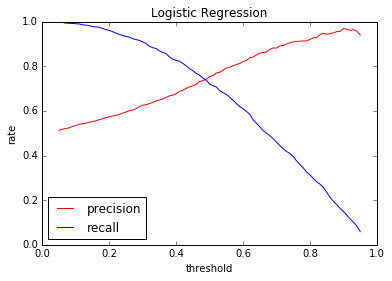

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

thresholds = []
precision = []
recall = []

for threshold in range(5, 96):
    y_pred = []
    
    for i in range(len(y_true)):
        if scores[i][1] > threshold * 0.01:
            y_pred.append(1)
        else:
            y_pred.append(0)
            
    thresholds.append(threshold * 0.01)
    precision.append(precision_score(y_true, y_pred))
    recall.append(recall_score(y_true, y_pred))

plt.plot(thresholds, precision, label="precision", color="red")
plt.plot(thresholds, recall, label="recall", color="blue")

plt.xlabel("threshold")
plt.ylabel("rate")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title("Logistic Regression")
plt.legend(loc = 3)

plt.show()